## Klassifikation der einzelnen Objecte im mvtec_anomaly_detection Dataset 

### Importieren der Bibliotheken und Files 

In [6]:
from read_and_label_Images_only_objects import read_and_label_Images_only_objects
from read_and_label_Images import read_and_label_Images
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import backend as K

In [3]:
%load_ext autoreload
%autoreload 2

### Einlesen des Datensatzes und in neuer Ordnerstruktur abspeichern

In [4]:
src_path="orginal_Dataset/mvtec_anomaly_detection/" #Angabe des Pfades zum Unveränderten Datensatz 
dst_path="Datasets/Set_01/" #Ablageort des neuen Datensatzes 


if not os.path.exists(dst_path): #Nur erstellen, wenn noch nicht vorhanden 
    read_and_label_Images_only_objects(src_path,dst_path) # Daten sind nur noach Objekt sortiert keine Sortierung nach gut und schlecht 


### Aufteilen der Daten in Trainings und Validierungsdaten 

In [5]:
# returns a tf.data.Dataset Object
training_set = image_dataset_from_directory(dst_path,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             batch_size=32,
                                             image_size=(150, 150),
                                             seed=1337,
                                             label_mode = 'categorical')

val_dataset = image_dataset_from_directory(dst_path,
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  batch_size=32,
                                                  image_size=(150, 150),
                                                  seed=1337,
                                                  label_mode = 'categorical')

Found 5354 files belonging to 15 classes.
Using 4284 files for training.
Found 5354 files belonging to 15 classes.
Using 1070 files for validation.


### Erstellen eigener Metrics 

In [8]:


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Erzeugen eines Data Augemnatation Layer mit Keras 

In [7]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

### Laden des vortrainierten Netzes (ResNetV2)

In [8]:
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)

## Erstellen und Trainieren des KI Modells

Input-Layer wird für unsere Bilder angepasst <br>
Danach kommt ein Data-Augmentation-Layer und Layer zum anpassen der Bilder<br>
Das Basis-Modell wird angefügt und die letzten Layer inklusive Output-Layer wird für unsere Ergebnisse angepasst


In [1]:
base_model.trainable = False


inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) 
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
#x = tf.keras.applications.InceptionResNetV2.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(15,activation='softmax')(x)
model = keras.Model(inputs, outputs)

NameError: name 'base_model' is not defined

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy',f1_m,precision_m, recall_m])

history = model.fit(training_set, epochs=2, validation_data=val_dataset, )


Epoch 1/2
134/134 [==============================] - 141s 977ms/step - loss: 0.4331 - accuracy: 0.9314 - f1_m: 0.8858 - precision_m: 0.9660 - recall_m: 0.8241 - val_loss: 0.1781 - val_accuracy: 0.9953 - val_f1_m: 0.9427 - val_precision_m: 0.9950 - val_recall_m: 0.8975
Epoch 2/2
107/134 [======================>.......] - ETA: 21s - loss: 0.1262 - accuracy: 0.9977 - f1_m: 0.9598 - precision_m: 0.9981 - recall_m: 0.9252

### Modell abspeichern

### Anzeigen der Metrics 

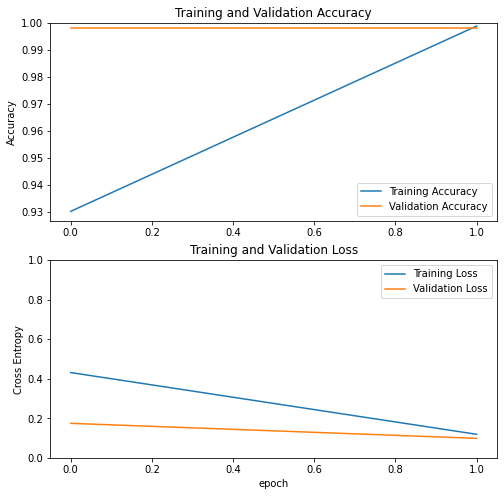

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Traineren des Modells: Fine-Tuning
Nun wird eingestellt, dass auch die Gewichte des Basis-Modells trainiert werden können. Jedoch nur mit geringer Lernrate

In [11]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy',f1_m,precision_m, recall_m]
)

history = model.fit(training_set, epochs=1, validation_data=val_dataset)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0     

### Anzeigen der Metrics 

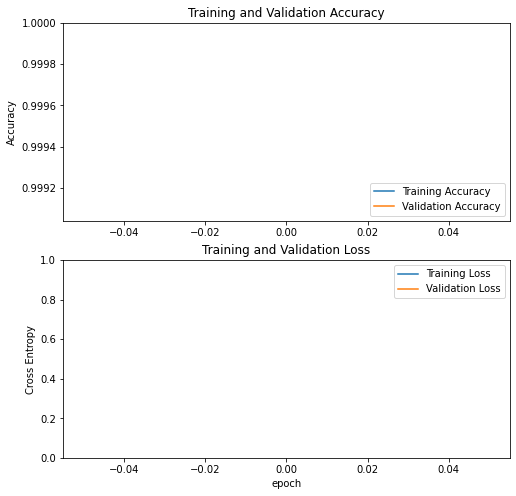

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Abspeichern des Trainierten Modells 

In [9]:
#model.save('Models/A1_TL_OO.h5')
loaded_model=keras.models.load_model('Models/A1_TL_OO.h5',custom_objects={"f1_m":f1_m,"precision_m":precision_m,"recall_m":recall_m})

### Bestimmen der Klasse mit dem Trainierten Modell 

Predicted Class: bottle
Predicted Class: wood


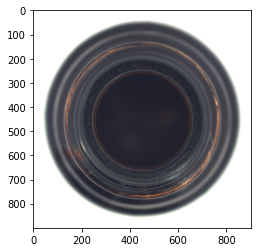

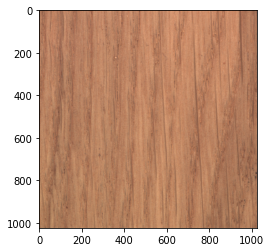

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def load(filename):
   np_image = cv2.imread(filename)
   np_image = cv2.resize(np_image, (150, 150))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

#TODO Images aus dem Validierungssatz nehmen 
image =[load('0a5d5050-1a2a-4dc4-a763-0eda0f1e03f8_bottle.png'),load('0b3597ff-e946-42f3-8c9f-5eb80447417c_wood.png')]
img=[mpimg.imread('0a5d5050-1a2a-4dc4-a763-0eda0f1e03f8_bottle.png'),mpimg.imread('0b3597ff-e946-42f3-8c9f-5eb80447417c_wood.png')]
labels=os.listdir(dst_path)
#array=model.predict(image)
for i in range(len(image)):
   array=loaded_model.predict(image[i])
   max_value=np.argmax(array)
   print("Predicted Class: {}".format(labels[max_value]))
   plt.figure(i+1)
   plt.imshow(img[i])

0
